In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_feynman1d
import dataset_feynman2d
import dataset_physics
import dataset_misc1d
import dataset_misc2d
import dataset_misc3d
import space
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 200
TRAIN_SIZE  = 0.7
NOISE       = 0.#05
MESH_SIZE   = 100

POPSIZE          = 100
MAX_STREE_DEPTH  = 5
MAX_STREE_LENGTH = 20
GENERATIONS      = 50
GROUP_SIZE       = 5  # tournament selector.
MUTATION_RATE    = 0.15
ELITISM          = 1

LIBSIZE       = 2000
LIB_MAXDEPTH  = 3
LIB_MAXLENGTH = 10

RANDSTATE = None#124

In [3]:
randstate.setstate(RANDSTATE)

S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()
#S = dataset_misc3d.Gravity()
#S = dataset_feynman2d.FeynmanICh6Eq20()
#S = dataset_feynman1d.FeynmanIICh27Eq16()
#S = dataset_physics.AircraftLift()

S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
#S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

solutionCreator = gp_creator.PTC2RandomSolutionCreator(nvars=S.nvars)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, MAX_STREE_LENGTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

mesh           = space.MeshSpace(S_train, S.knowledge, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, mesh)
r2_evaluator   = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, r2_evaluator)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH, MAX_STREE_LENGTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, MAX_STREE_LENGTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover,
               mutator=multiMutator,
               corrector=corrector,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               knowledge=S.knowledge)

import profiling

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
print(f"Length: {best_stree.get_nnodes()}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/49 [00:00<?, ?it/s]

         2057431 function calls (1835356 primitive calls) in 5.926 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4900    0.136    0.000    5.832    0.001 corrector.py:31(correct)
     4700    0.086    0.000    3.265    0.001 library.py:515(cquery)
     3985    0.242    0.000    2.904    0.001 library.py:563(__local_cquery)
   101304    0.451    0.000    1.901    0.000 constraints.py:55(match_key)
     4900    0.060    0.000    1.524    0.000 corrector.py:84(backprop_know)
    93846    0.168    0.000    1.451    0.000 <__array_function__ internals>:177(array_equal)
    93846    0.811    0.000    1.260    0.000 numeric.py:2407(array_equal)
     4803    0.011    0.000    0.839    0.000 library.py:78(query)
     4803    0.554    0.000    0.828    0.000 _kdtree.py:363(query)
45000/9007    0.107    0.000    0.578    0.000 binop.py:29(__getitem__)
   219224    0.537    0.000    0.537    0.000 _methods.py:61(_all)
30903/15

In [5]:
profiling.print_stats()

         2057431 function calls (1835356 primitive calls) in 5.926 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4900    0.136    0.000    5.832    0.001 corrector.py:31(correct)
     4700    0.086    0.000    3.265    0.001 library.py:515(cquery)
     3985    0.242    0.000    2.904    0.001 library.py:563(__local_cquery)
   101304    0.451    0.000    1.901    0.000 constraints.py:55(match_key)
     4900    0.060    0.000    1.524    0.000 corrector.py:84(backprop_know)
    93846    0.168    0.000    1.451    0.000 <__array_function__ internals>:177(array_equal)
    93846    0.811    0.000    1.260    0.000 numeric.py:2407(array_equal)
     4803    0.011    0.000    0.839    0.000 library.py:78(query)
     4803    0.554    0.000    0.828    0.000 _kdtree.py:363(query)
45000/9007    0.107    0.000    0.578    0.000 binop.py:29(__getitem__)
   219224    0.537    0.000    0.537    0.000 _methods.py:61(_all)
30903/15

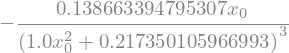

In [6]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

In [7]:
best_stree.clear_output()
#S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)
S.evaluate_extra(best_stree)

{'mse': 5.704560914144172e-07,
 'rmse': 0.0007552854370464303,
 'r2': 0.999998561446322}

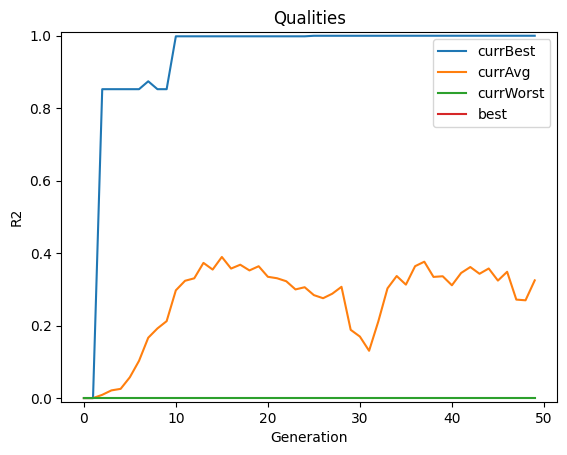

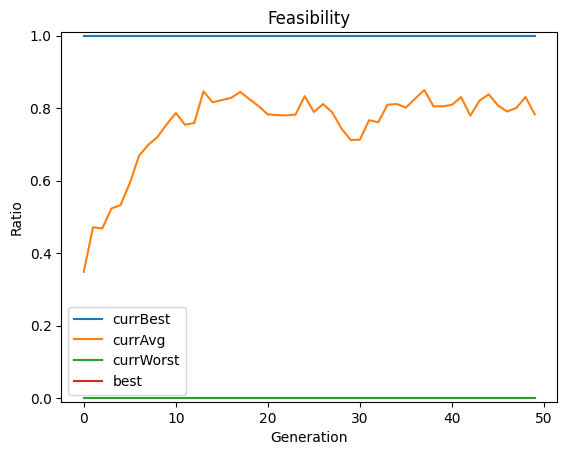

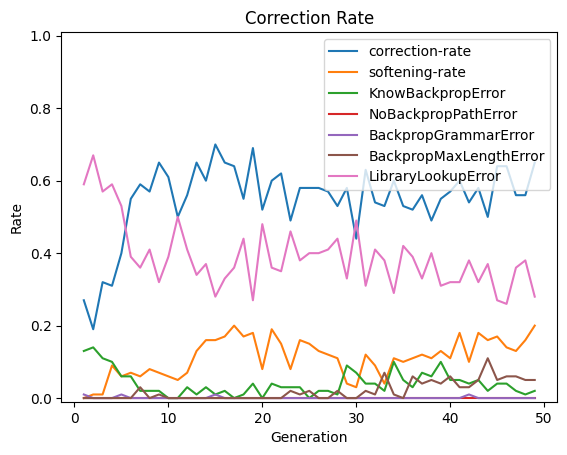

In [8]:
symb_regressor.stats.plot()

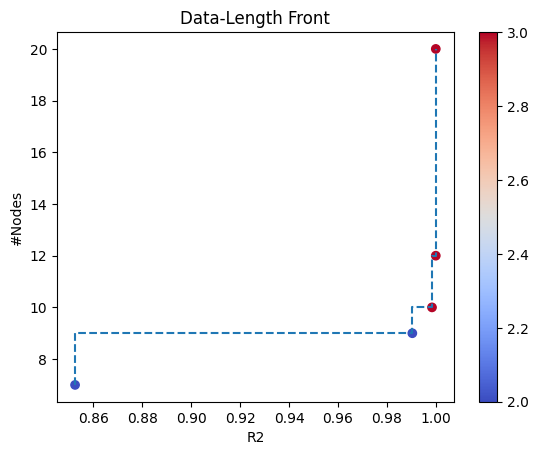

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,(x0 / cube((-0.54 - square(x0)))),0,0.554141,0.852525,7,"(/, square, cube)",2,inf
1,1,((((-0.41 * x0) + (x0 / 0.64)) * 0.97) / cube(...,0,0.000000,0.999999,20,"(+, /, square, cube)",3,inf
2,2,((x0 * 0.14) / cube((-0.23 - square(x0)))),0,0.544722,0.990404,9,"(/, square, cube)",2,1.220244
3,3,((x0 * 1.10) / cube(((-0.43 - square(x0)) - sq...,0,0.399998,0.999995,12,"(+, /, square, cube)",3,0.779756
4,4,(x0 / cube(((-0.41 - square(x0)) - square(x0)))),0,0.499223,0.998446,10,"(+, /, square, cube)",3,0.295804
5,0,(x0 / cube((-0.57 - square(x0)))),1,0.526678,0.810274,7,"(/, square, cube)",2,inf
6,1,(((square(x0) - (square(x0) - x0)) * 1.10) / c...,1,0.099999,0.999995,18,"(+, /, square, cube)",4,inf
7,2,((x0 / 0.93) / cube((-0.54 - square(x0)))),1,0.469351,0.853366,9,"(/, square, cube)",2,1.254488
8,3,(x0 / cube((-0.41 - ((x0 / 0.52) * x0)))),1,0.498267,0.996535,10,"(*, /, cube)",1,1.042356
9,4,((x0 / 0.93) / cube(((-0.43 - square(x0)) - sq...,1,0.399752,0.999381,12,"(+, /, square, cube)",4,0.380980


In [9]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data*(1.-min(1.,length/20)), data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)